### Importing Data
ref:  https://github.com/Kaggle/kaggle-api and
https://www.kaggle.com/discussions/general/74235

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezajsh","key":"0c18fd25e0aecbc3fa70759b7cff0840"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
ls -a

./  ../  .config/  drive/  kaggle.json  sample_data/


In [5]:
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


Kaggle dataset for traffic sign

ref:
https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data

In [6]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 607M/612M [00:03<00:00, 186MB/s]
100% 612M/612M [00:03<00:00, 164MB/s]


In [7]:
!ls -a

.  ..  gtsrb-german-traffic-sign.zip


In [8]:
%cd ..

/content


In [ ]:
! unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset

In [10]:
#importing libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [11]:
#paths to test and train data
train_dir = 'traffic_sign_dataset/Train/'
test_dir = 'traffic_sign_dataset/Test/'

In [12]:
# Resizing the images to 51x51x3(colors)
IMG_HEIGHT = 51
IMG_WIDTH = 51
channels = 3
BATCH_SIZE=32

In [13]:
# number of classes
print('Number off total classes:\n')
NUM_CATEGORIES = len(os.listdir(train_dir))
NUM_CATEGORIES

Number off total classes:



43

In [14]:
# Label Overview
#assigning actual names to the classes
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

### EDA

In [15]:
df = pd.read_csv('traffic_sign_dataset/Train.csv')

In [16]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


 Mean values of Heigth and Width are assigned to Constants IMG_HEIGHT and IMG_WIDTH earlier defined.

In [18]:
columns = ['Width' , 'Height' , 'ClassId']
df[columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Width,39209.0,50.83588,24.306933,25.0,35.0,43.0,58.0,243.0
Height,39209.0,50.32893,23.115423,25.0,35.0,43.0,58.0,225.0
ClassId,39209.0,15.78839,12.013238,0.0,5.0,12.0,25.0,42.0


Now let's count and plot the total number of images in each class

In [19]:
classId_counts = df['ClassId'].value_counts()
classId_counts.index =  classId_counts.index.map(classes)


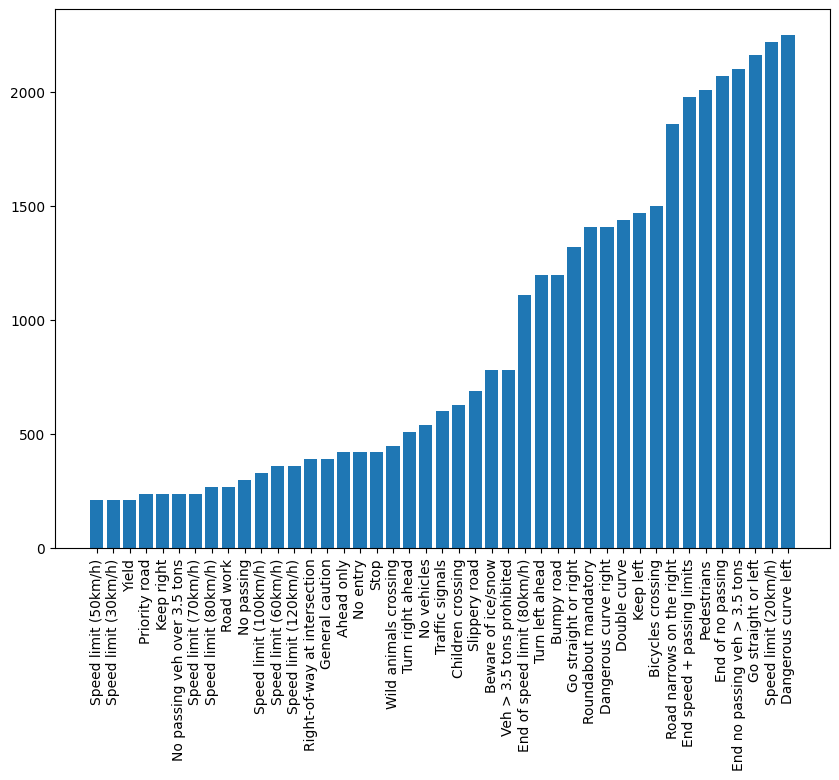

In [20]:
# Plotting the number of images in each class
plt.figure(figsize=(10,7))
plt.bar(classId_counts.index , classId_counts.sort_values())
plt.xticks(rotation='vertical')
plt.show()

In [21]:
print('The ratio between maximum counts of images to minimum counts:')
print(round(classId_counts.max() / classId_counts.min()))

The ratio between maximum counts of images to minimum counts:
11


In [22]:
class_names = ['Speed limit (20km/h)','Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)',
            'No passing',
            'No passing veh over 3.5 tons',
            'Right-of-way at intersection',
            'Priority road',
            'Yield',
            'Stop',
            'No vehicles',
            'Veh > 3.5 tons prohibited',
            'No entry',
            'General caution',
            'Dangerous curve left',
            'Dangerous curve right',
            'Double curve',
            'Bumpy road',
            'Slippery road',
            'Road narrows on the right',
            'Road work',
            'Traffic signals',
            'Pedestrians',
            'Children crossing',
            'Bicycles crossing',
            'Beware of ice/snow',
            'Wild animals crossing',
            'End speed + passing limits',
            'Turn right ahead',
            'Turn left ahead',
            'Ahead only',
            'Go straight or right',
            'Go straight or left',
            'Keep right',
            'Keep left',
            'Roundabout mandatory',
            'End of no passing',
            'End no passing veh > 3.5 tons']

In [23]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    subset="both",
    seed=101,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Using 7841 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)


['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


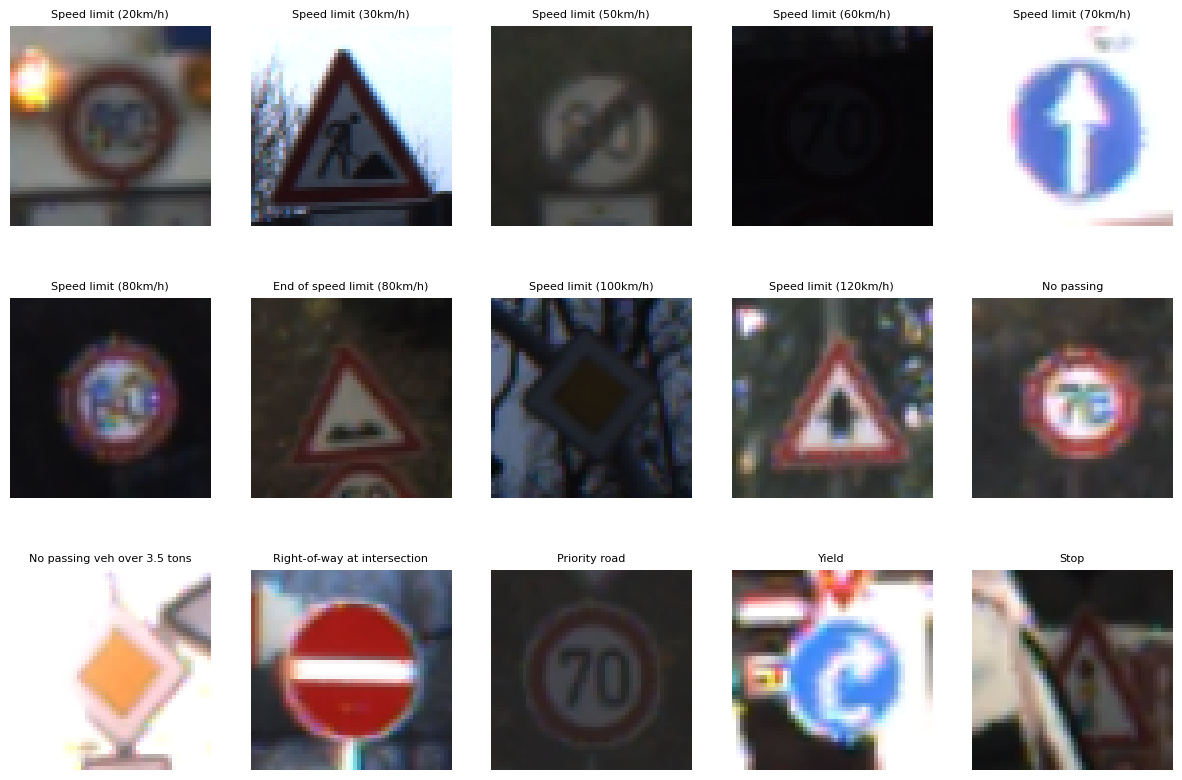

In [90]:
#Visualize the data
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[i],fontsize = 8)
    plt.axis("off")

In [26]:
#shapes
for image_batch, labels_batch in train_ds:
  print('Shape of images: ', image_batch.shape)
  print('Shape of batches:' ,labels_batch.shape)
  break

Shape of images:  (32, 51, 51, 3)
Shape of batches: (32, 43)


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Building the model

first model uses no image augmentation

and second model uses image augmentation

In [28]:
#function for plottimg losses and validations
def plot_loss_accuracy(history):
  """
    Plots the training and validation accuracy, and training and validation loss.

    Args:
        history: The history object returned by the `model.fit()` function.
    """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [29]:
NUMBER_OF_CLASSES = len(class_names)
EPOCHS=30

In [30]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(NUMBER_OF_CLASSES, activation='softmax'),
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 51, 51, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 51, 51, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 32)        9248      
                                                        

In [33]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/30
981/981 [==============================] - 29s 13ms/step - loss: 2.0976 - accuracy: 0.3761 - val_loss: 0.5510 - val_accuracy: 0.8127
Epoch 2/30
981/981 [==============================] - 8s 9ms/step - loss: 0.2798 - accuracy: 0.9090 - val_loss: 0.1571 - val_accuracy: 0.9482
Epoch 3/30
981/981 [==============================] - 9s 9ms/step - loss: 0.1017 - accuracy: 0.9694 - val_loss: 0.0869 - val_accuracy: 0.9733
Epoch 4/30
981/981 [==============================] - 9s 10ms/step - loss: 0.0775 - accuracy: 0.9768 - val_loss: 0.0626 - val_accuracy: 0.9823
Epoch 5/30
981/981 [==============================] - 9s 9ms/step - loss: 0.0460 - accuracy: 0.9858 - val_loss: 0.0628 - val_accuracy: 0.9814
Epoch 6/30
981/981 [==============================] - 10s 10ms/step - loss: 0.0522 - accuracy: 0.9844 - val_loss: 0.0631 - val_accuracy: 0.9815
Epoch 7/30
981/981 [==============================] - 10s 10ms/step - loss: 0.0518 - accuracy: 0.9851 - val_loss: 0.1015 - val_accuracy: 0.9694

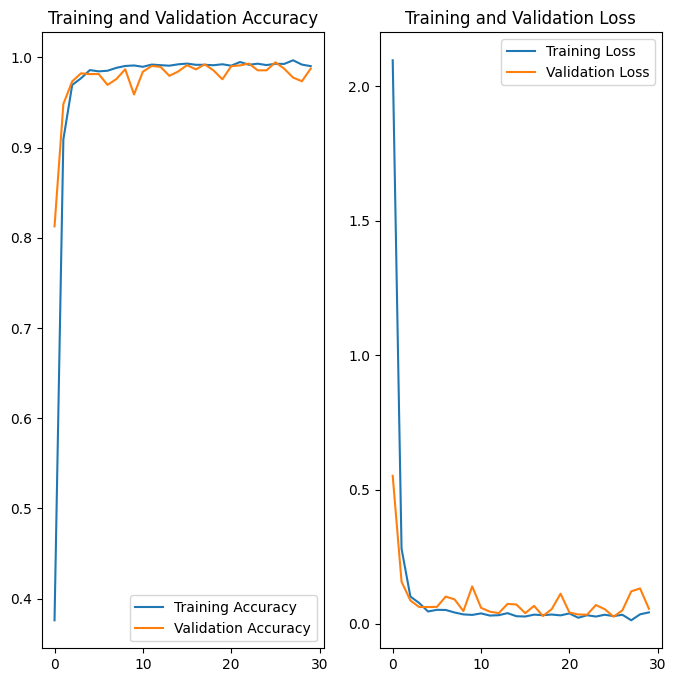

In [34]:
plot_loss_accuracy(history)

In [35]:
model.evaluate(val_ds)

246/246 [==============================] - 1s 3ms/step - loss: 0.0561 - accuracy: 0.9875


[0.05607043206691742, 0.9875016212463379]

In [36]:
def get_misclassified_images(model, val_ds):
    """
    Retrieves the misclassified images and labels from a given model and validation dataset.

    Parameters:
    model (tf.keras.Model): The trained model.
    val_ds (tf.data.Dataset): The validation dataset.

    Returns:
    misclassified_images (numpy.ndarray): Array of misclassified images.
    misclassified_labels (numpy.ndarray): Array of misclassified labels.
    predictions (numpy.ndarray): Array of predicted labels.
    labels (numpy.ndarray): Array of true labels.
    """

    misclassified_images = []
    misclassified_labels = []
    predictions = np.array([])
    labels = np.array([])

    for x, y in val_ds:
        predicted = np.argmax(model.predict(x), axis=-1)
        lbl = np.argmax(y.numpy(), axis=-1)

        labels = np.concatenate([labels, lbl])
        predictions = np.concatenate([predictions, predicted])

        misclassified = lbl != predicted
        misclassified_images.extend(x[misclassified])
        misclassified_labels.extend(predicted[misclassified])

    misclassified_images = np.array(misclassified_images)
    misclassified_labels = np.array(misclassified_labels)

    return misclassified_images, misclassified_labels, predictions, labels


def plot_confusion_matrix(labels, predictions):
    """
    Plots the confusion matrix based on the provided labels and predictions.

    Parameters:
    labels (array-like): True labels.
    predictions (array-like): Predicted labels.
    """

    # Create the confusion matrix display from the labels and predictions
    disp = ConfusionMatrixDisplay.from_predictions(labels, predictions, xticks_rotation=90, cmap='Blues', values_format='d')
    fig = disp.figure_

    # Set the figure width and height
    fig.set_figwidth(12)
    fig.set_figheight(12)

    # Set the font size for x and y tick labels
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Set the colorbar font size
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=8)

    # Set the title and labels
    plt.title('Confusion Matrix', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

def display_random_misclassified_images(misclassified_images, misclassified_labels, classes, num_images=15):
    """
    Displays a random selection of misclassified images with their predicted labels.

    Parameters:
    misclassified_images (numpy.ndarray): Array of misclassified images.
    misclassified_labels (numpy.ndarray): Array of misclassified labels.
    classes (list): List of class labels.
    num_images (int): Number of images to display. Default is 15.
    """

    random_indexes = np.random.choice(len(misclassified_images), size=num_images, replace=False)
    misclassified_images = misclassified_images[random_indexes]
    misclassified_labels = misclassified_labels[random_indexes]

    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(misclassified_images[i].astype('uint8'))
        ax.set_title(f"Predicted: {classes[i]}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [37]:
misclassified_images, misclassified_labels , predictions, labels = get_misclassified_images(model, val_ds)

1/1 [==============================] - 0s 129ms/step


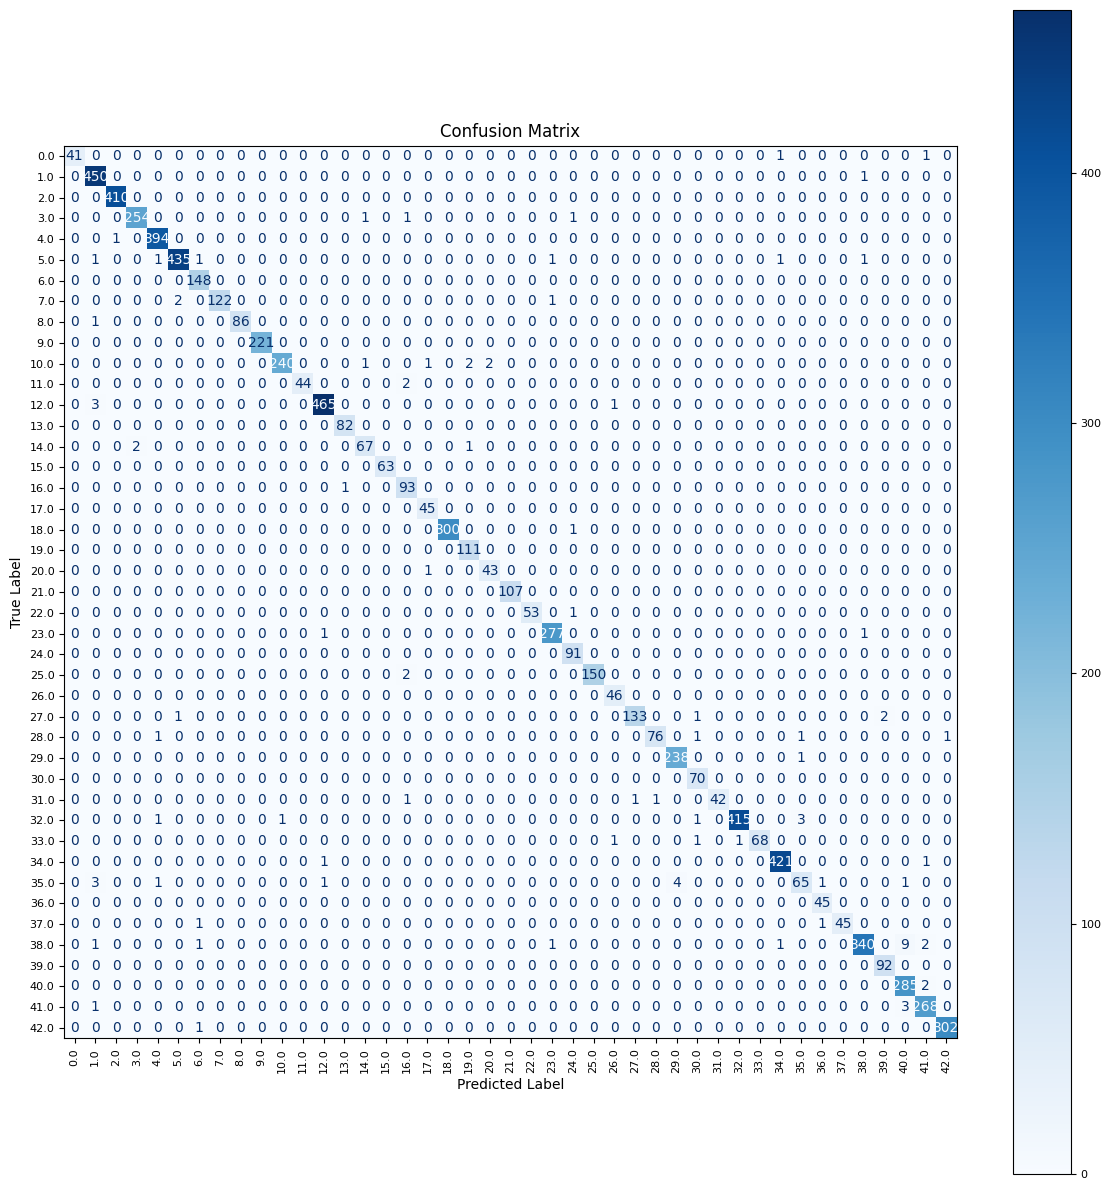

In [38]:
plot_confusion_matrix(labels, predictions)

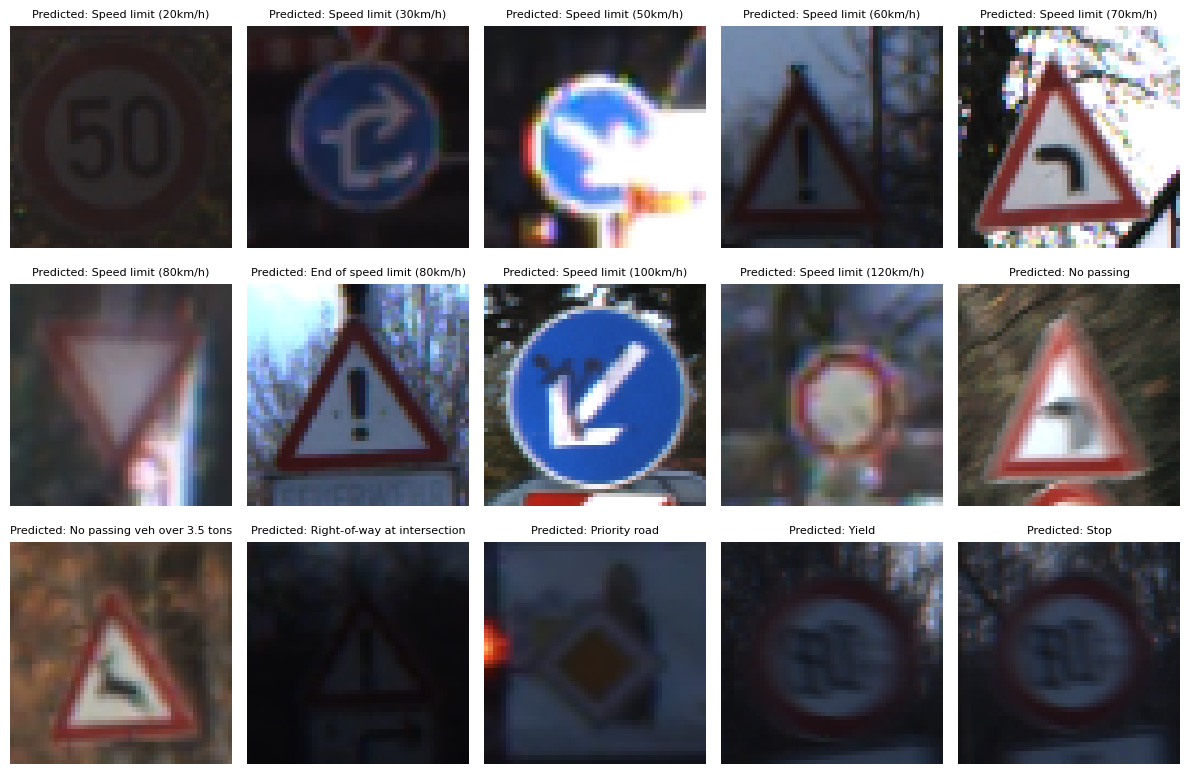

In [39]:
#sample missclassified images
display_random_misclassified_images(misclassified_images, misclassified_labels, classes)


Now we add augmentation to image

In [40]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(.15, .15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(.1),
    layers.RandomBrightness(.1),
  ]
)

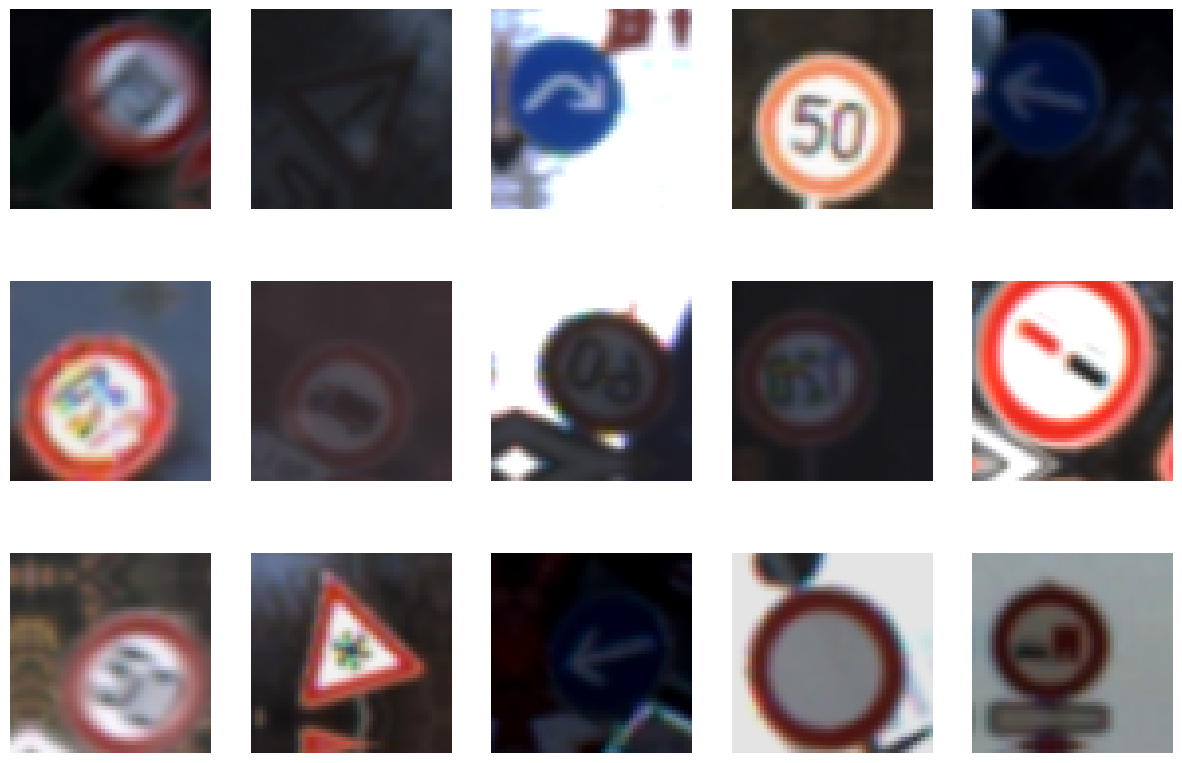

In [41]:
#adding augmentation to trianing images
plt.figure(figsize=(15, 10))
for images, _ in train_ds.take(1):
  for i in range(15):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

In [42]:
model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(NUMBER_OF_CLASSES, activation='softmax'),
])

In [43]:
model_aug.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model_aug.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 51, 51, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 51, 51, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 51, 16)        448       
                                                                 
 conv2d_11 (Conv2D)          (None, 51, 51, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 25, 32)        4640      
                                                      

In [45]:
history_aug= model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


981/981 [==============================] - 17s 13ms/step - loss: 3.5028 - accuracy: 0.0533 - val_loss: 3.4866 - val_accuracy: 0.0537
Epoch 2/30
981/981 [==============================] - 12s 13ms/step - loss: 3.4718 - accuracy: 0.0652 - val_loss: 3.3847 - val_accuracy: 0.0897
Epoch 3/30
981/981 [==============================] - 12s 12ms/step - loss: 3.0444 - accuracy: 0.1392 - val_loss: 2.4134 - val_accuracy: 0.2359
Epoch 4/30
981/981 [==============================] - 13s 13ms/step - loss: 1.8961 - accuracy: 0.3715 - val_loss: 1.4615 - val_accuracy: 0.4836
Epoch 5/30
981/981 [==============================] - 11s 12ms/step - loss: 1.4276 - accuracy: 0.5092 - val_loss: 1.1299 - val_accuracy: 0.6007
Epoch 6/30
981/981 [==============================] - 12s 13ms/step - loss: 1.1554 - accuracy: 0.5979 - val_loss: 0.8687 - val_accuracy: 0.6905
Epoch 7/30
981/981 [==============================] - 13s 13ms/step - loss: 0.9307 - accuracy: 0.6771 - val_loss: 0.7013 - val_accuracy: 0.7503
Epo

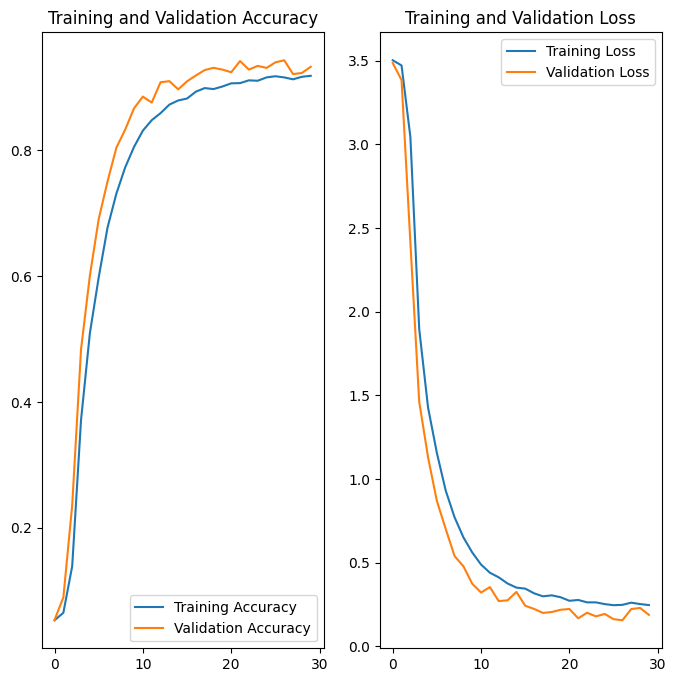

In [46]:
plot_loss_accuracy(history_aug)

In [47]:
model_aug.evaluate(val_ds)

246/246 [==============================] - 1s 4ms/step - loss: 0.1882 - accuracy: 0.9324


[0.18823786079883575, 0.9324066042900085]

In [48]:
misclassified_images_aug, misclassified_labels_aug , predictions_aug, labels_aug = get_misclassified_images(model_aug, val_ds)

1/1 [==============================] - 0s 150ms/step


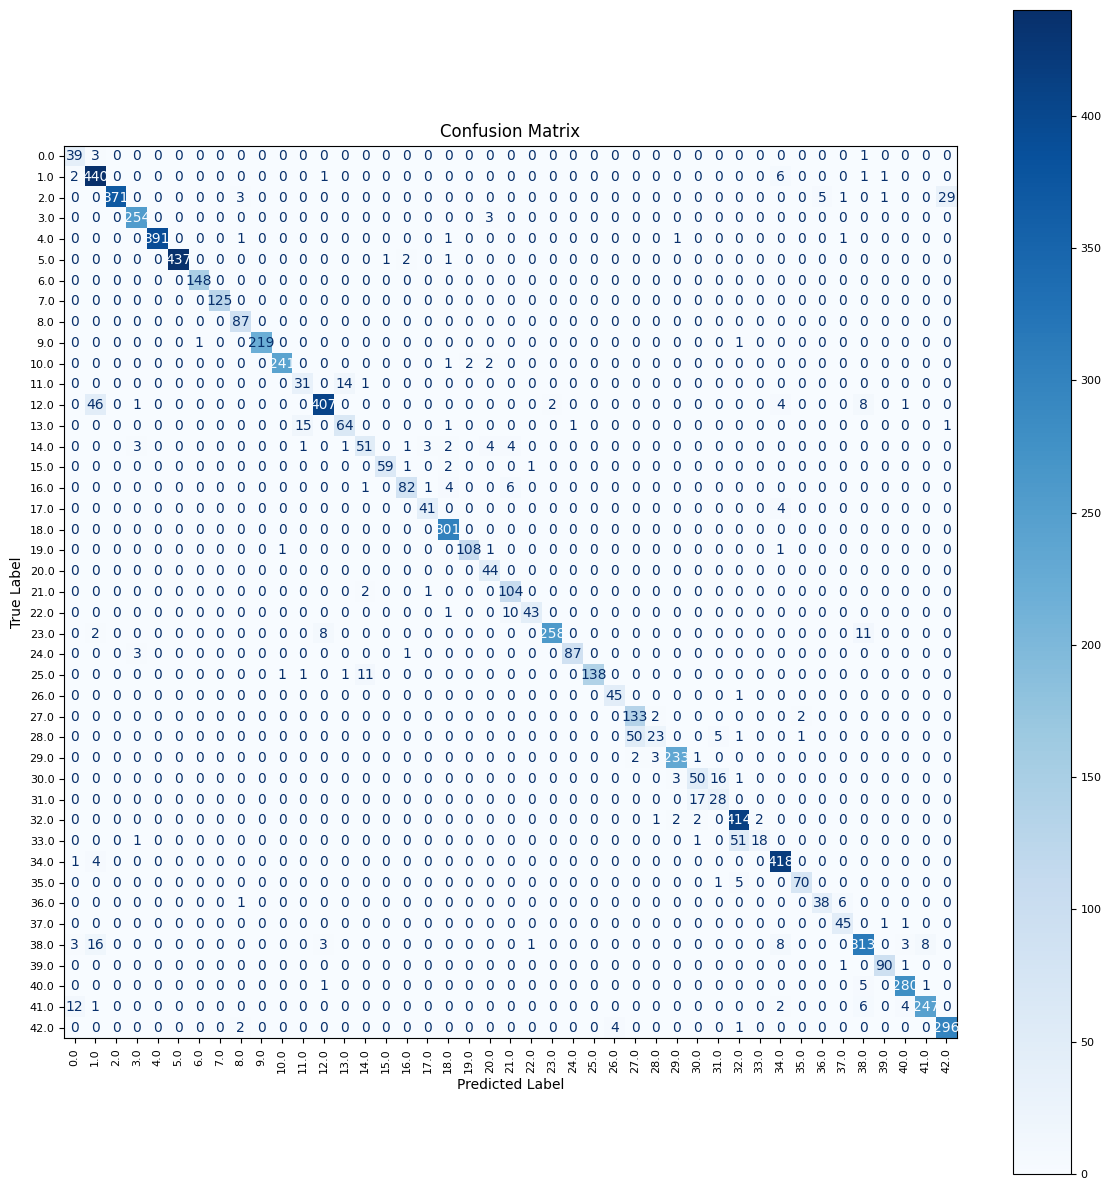

In [49]:
plot_confusion_matrix(labels_aug, predictions_aug)

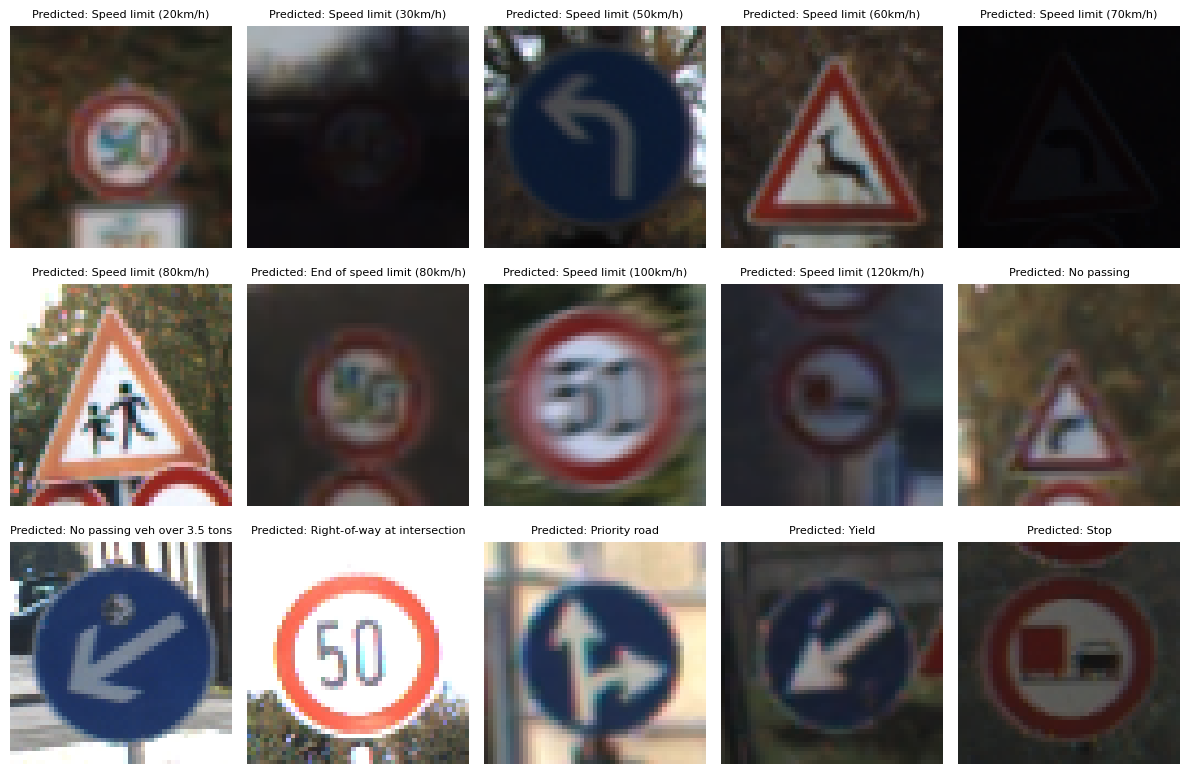

In [50]:
#missclassified  on augmented image
display_random_misclassified_images(misclassified_images_aug, misclassified_labels_aug, classes)


### Predict on new data

In [65]:
def get_test_images(model, labels, class_names, image_paths, size = 1):
    predictions = []
    true_labels = []
    images = []
    random_indices = np.random.randint(0, len(image_paths), size)
    for i, img in list(zip(random_indices , image_paths[random_indices])):
      image = tf.keras.utils.load_img(
        'traffic_sign_dataset/' + img , target_size=(IMG_HEIGHT, IMG_WIDTH))
      image = tf.keras.utils.img_to_array(image)
      image = tf.expand_dims(image, 0) # Create a batch
      images.append(image)
      pred = model.predict(image)
      score = tf.nn.softmax(pred)
      predicted_class = class_names[np.argmax(score)]
      predicted_prob = 100 * np.max(score)
      predictions.append(int(predicted_class))
      true_labels.append(labels[i])

    return predictions, true_labels, images


def display_random_test_images(images, true_labels, predictions, num_images=15):
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8))

    for i, ax in enumerate(axes.flat):
        if int(predictions) != int(true_labels):
          col = 'r'
        else:
          col = 'g'
        ax.imshow(images[i].astype('uint8'))
        # ax.set_title(f"Predicted: {classes[i]}", fontsize=8)
        ax.xlabel('Actual={} || Pred={}'.format(classes[int(labels[i])],
                                                 classes[int(predicted_class)]),
                   color = col , fontsize=8)
        # plt.imshow(pic)
        # ax.axis('off')

    plt.tight_layout()
    plt.show()


In [86]:

def plot_images(predictions, true_labels, images, class_names, image_width=800, image_height=600):
    num_images = len(images)
    num_columns = 5

    num_rows = (num_images + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))

    for i, (pred, true_label, image) in enumerate(zip(predictions, true_labels, images)):
        row = i // num_columns
        col = i % num_columns

        axes[row, col].imshow(image[0].numpy().astype('uint8'))
        title = f'Prediction: {class_names[pred]}\nTrue Label: {class_names[true_label]}'

        if int(pred) != int(true_label):
            axes[row, col].title.set_color('red')
        else:
            axes[row, col].title.set_color('green')

        axes[row, col].set_title(title, fontsize=8)
        axes[row, col].axis('off')

    # Remove any empty subplots
    if num_images < num_rows * num_columns:
        for j in range(num_images, num_rows * num_columns):
            row = j // num_columns
            col = j % num_columns
            fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

In [66]:

df_test = pd.read_csv('traffic_sign_dataset/Test.csv')

In [67]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [55]:
labels = df_test['ClassId'].values
image_paths = df_test['Path'].values

In [ ]:
predictions , true_labels, images = get_test_images(model, labels, class_names, image_paths, size=20)

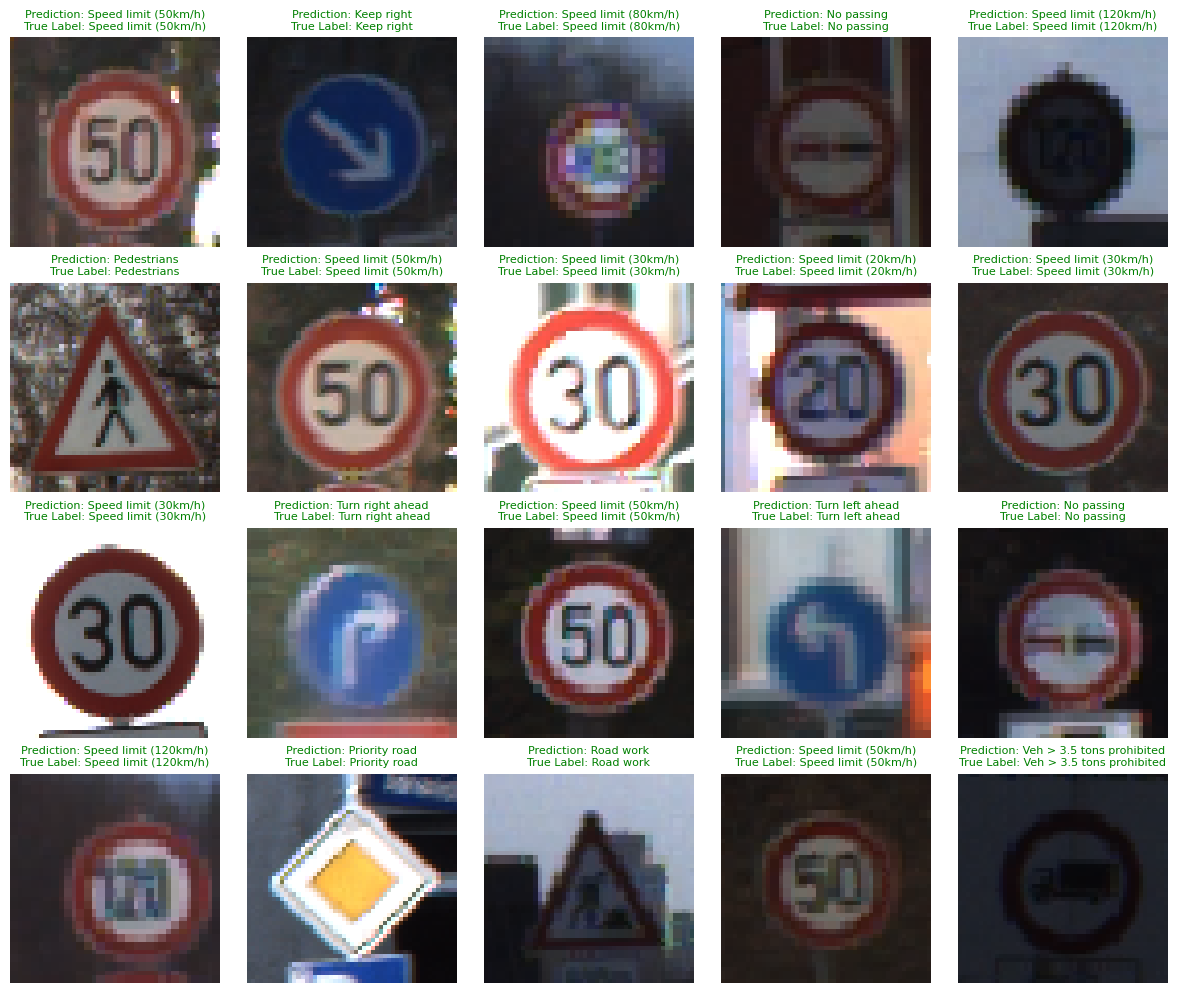

In [87]:
plot_images(predictions, true_labels, images, classes)
